In [1]:
from neo4j import GraphDatabase
import pandas as pd
import networkx as nx
from node2vec import Node2Vec

In [2]:
driver = GraphDatabase.driver("bolt://localhost:7687", auth=("neo4j","123456789"))
with driver.session() as session:
    result = session.run("MATCH (p:KnownTopic)-[:CITES]->(q:Paper) RETURN id(p) AS source, id(q) AS target")
    edge_list = [(r["source"], r["target"]) for r in result]
    result = session.run("MATCH (p:KnownTopic) RETURN id(p) AS node, p.domainEncoding AS encoding")
    labeled = [(r["node"], r["encoding"]) for r in result]

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated function: `id`.} {position: line: 1, column: 49, offset: 48} for query: 'MATCH (p:KnownTopic)-[:CITES]->(q:Paper) RETURN id(p) AS source, id(q) AS target'
Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated function: `id`.} {position: line: 1, column: 66, offset: 65} for query: 'MATCH (p:KnownTopic)-[:CITES]->(q:Paper) RETURN id(p) AS source, id(q) AS target'
Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {

In [3]:
edge_df = pd.DataFrame(edge_list, columns=["source", "target"])
G = nx.from_pandas_edgelist(edge_df, source='source', target='target', create_using=nx.DiGraph())

In [4]:
node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=100, workers=4)
model = node2vec.fit(window=10, min_count=1)

Computing transition probabilities:   0%|          | 0/115111 [00:00<?, ?it/s]

In [5]:
embeddings = {int(node): model.wv[node] for node in model.wv.index_to_key}

In [6]:
nodes = pd.unique(edge_df[['source', 'target']].values.ravel())
print(nodes.shape)

(115111,)


In [7]:
labels = {}
for node, label in labeled:
    labels[node] = label

In [8]:
# create a DataFrame with one row per node and 3 columns, node id, embedding, and encoding
data_df = pd.DataFrame({
    'node': nodes,
    'embedding': [embeddings.get(node, None) for node in nodes],
    'encoding': [labels.get(node, None) for node in nodes]
})
# drop all rows with None in the embedding or encoding column
data_df = data_df.dropna(subset=['embedding', 'encoding'])

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

In [10]:
# Prepare input (X) and output (Y)
X = np.vstack(data_df['embedding'].values)
Y = np.array(data_df['encoding'].tolist())  # assuming each encoding is a list of 20 binary values

# Train-test split (70% train, 30% test)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [11]:
# Random Forest for multi-label classification
rf_classifier = OneVsRestClassifier(RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1))
rf_classifier.fit(X_train, Y_train)

OneVsRestClassifier(estimator=RandomForestClassifier(n_estimators=200,
                                                     n_jobs=-1,
                                                     random_state=42))

In [12]:
# Predictions
Y_pred = rf_classifier.predict(X_test)

# Evaluation
print("Classification Report:\n", classification_report(Y_test, Y_pred))
print("Subset Accuracy:", accuracy_score(Y_test, Y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.40      0.01      0.01       329
           1       0.33      0.00      0.01       332
           2       0.43      0.09      0.15       686
           3       0.63      0.94      0.76      1066
           4       0.00      0.00      0.00       122
           5       0.00      0.00      0.00       236
           6       1.00      0.00      0.01       313
           7       0.00      0.00      0.00       282
           8       0.25      0.00      0.00       503
           9       0.00      0.00      0.00       469
          10       0.71      0.01      0.02       426
          11       0.00      0.00      0.00       330
          12       0.00      0.00      0.00       359
          13       0.00      0.00      0.00       177
          14       0.00      0.00      0.00       226
          15       0.00      0.00      0.00       140
          16       0.50      0.00      0.00       447
   

c:\Users\AhmedAli\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\AhmedAli\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


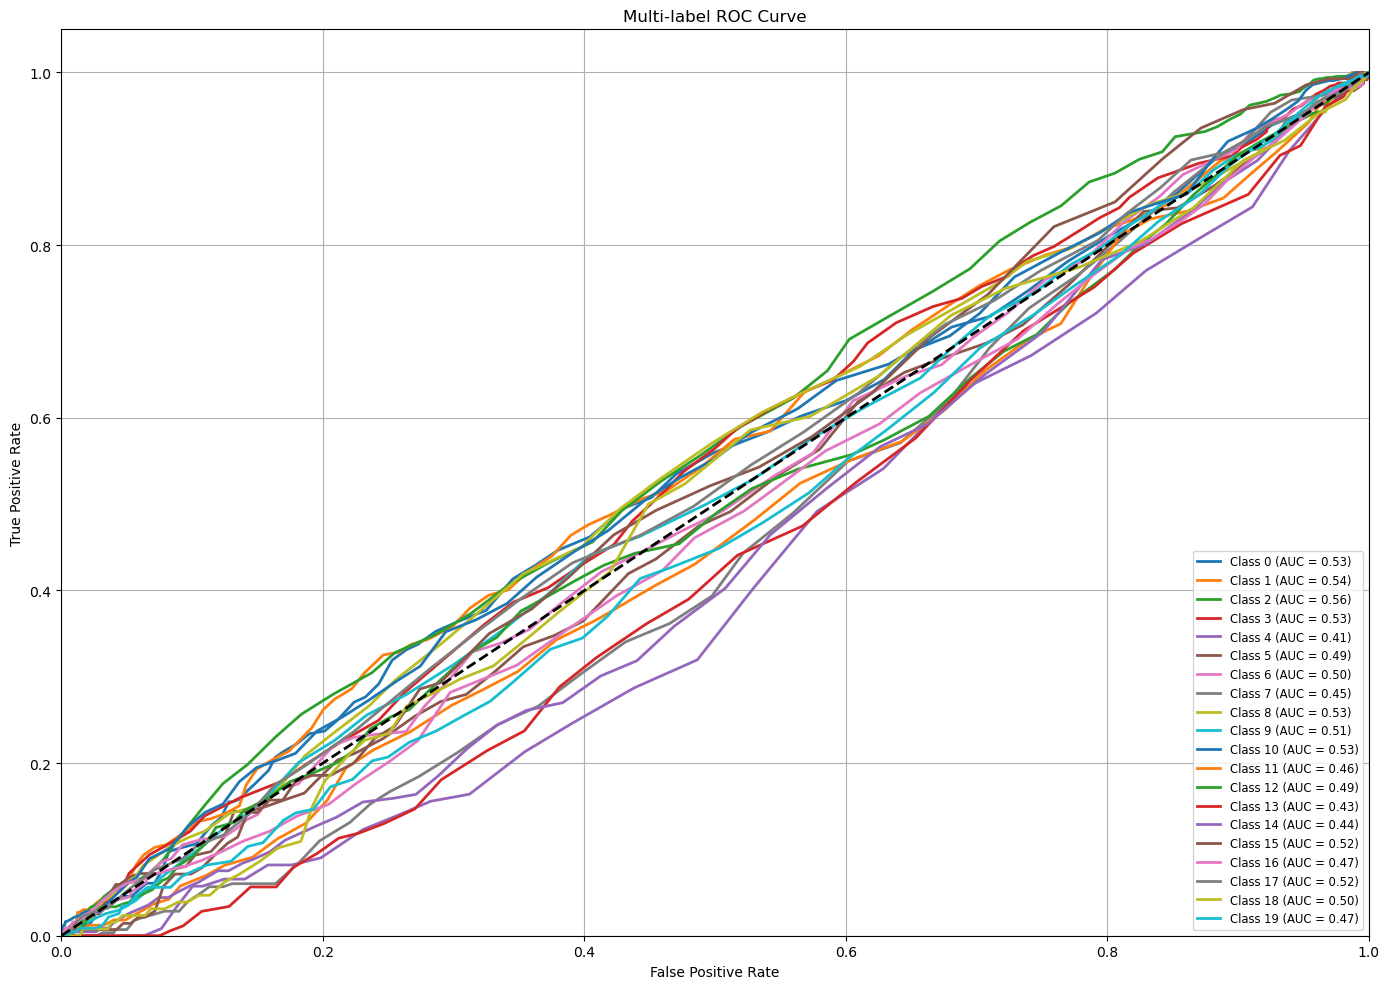

In [17]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get predicted probabilities
Y_score = rf_classifier.predict_proba(X_test)

# Initialize dictionaries
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = Y_test.shape[1]

# Compute ROC curve and AUC for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], Y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(14, 10))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-label ROC Curve')
plt.legend(loc='lower right', fontsize='small')
plt.grid()
plt.tight_layout()
plt.show()
